In [1]:
# 랜덤성 제어를 위한 seed 고정
import torch
import random
import numpy as np

seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [2]:
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
import pandas as pd
import json

import matplotlib.pyplot as plt

In [3]:
from glob import glob

In [4]:
data_path = '/home/kim/Desktop/AI_project02/Kaggle02'

In [5]:
json.load(open(f"{data_path}/class_name.json"))

{'Fish': 0,
 'Plant': 1,
 'Utensil': 2,
 'Insect': 3,
 'Appliance': 4,
 'Bird': 5,
 'Building': 6,
 'Clothing': 7,
 'Food': 8,
 'Structure': 9,
 'Container': 10,
 'Tool': 11,
 'SportsEquipment': 12,
 'Electronic': 13,
 'Reptile': 14,
 'Weapon': 15,
 'Mammal': 16,
 'MusicalInstrument': 17,
 'GeologicalFormation': 18,
 'Furniture': 19,
 'Vehicle': 20}

In [6]:
classes = json.load(open(f"{data_path}/class_name.json"))

In [7]:
classes.keys()

dict_keys(['Fish', 'Plant', 'Utensil', 'Insect', 'Appliance', 'Bird', 'Building', 'Clothing', 'Food', 'Structure', 'Container', 'Tool', 'SportsEquipment', 'Electronic', 'Reptile', 'Weapon', 'Mammal', 'MusicalInstrument', 'GeologicalFormation', 'Furniture', 'Vehicle'])

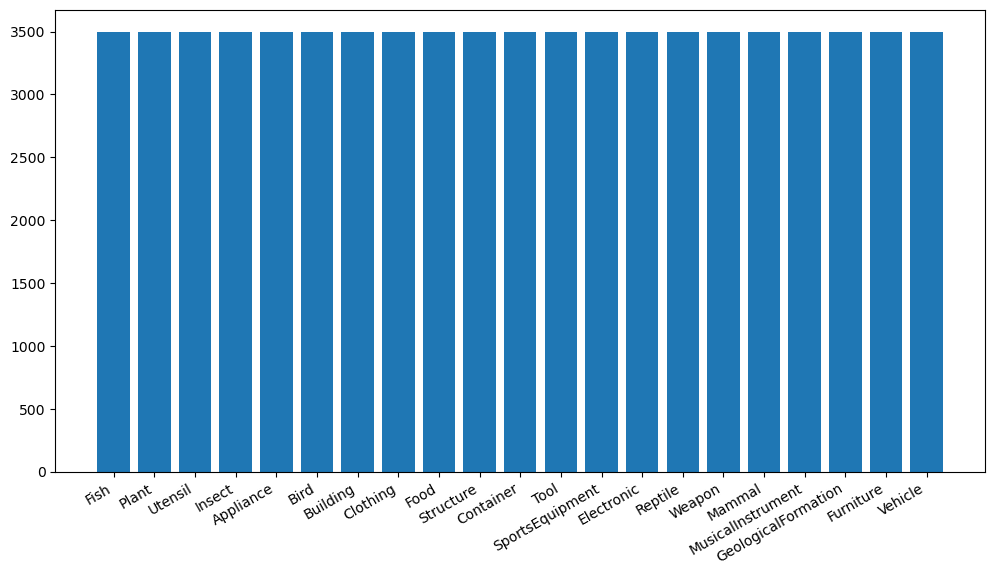

In [8]:
class_names = list(classes.keys())
counter = [0] * len(class_names)
for i, class_name in enumerate(class_names):
    counter[i] = len(glob(f"{data_path}/train/{class_name}/*.JPEG"))
plt.figure(figsize=(12,6))
plt.bar(class_names,counter)
plt.xticks(rotation=30,ha='right')
plt.show()

In [9]:
from glob import glob

class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train

        self.name2label = json.load(open(f"{data_path}/class_name.json"))


        if self.train:
            self.img_path = glob(f"{data_path}/train/*/*.JPEG") # list
            self.labels =  [self.name2label[d.split("/")[-2]] for d in self.img_path] # 숫자 라벨 리스트
        else:
            self.img_path = glob(f"{data_path}/test/*.JPEG")

        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')


        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

In [10]:
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        # subset에서 이미지를 가져옴 (원본의 transform이 적용된 상태일 수 있음)
        # 따라서 원본 MyDataset에서 transform=None으로 설정하는 것이 가장 깔끔합니다.
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [11]:
data_path = '/home/kim/Desktop/AI_project02/Kaggle02'
train_transform =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4702, 0.4475, 0.3954],[0.2293, 0.2246, 0.2261]) #(tensor([0.4702, 0.4475, 0.3954]), tensor([0.2293, 0.2246, 0.2261]))
])

test_transform =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4702, 0.4475, 0.3954],[0.2293, 0.2246, 0.2261]) ################# 나중에 바꿀것
])

train_data = MyDataset(data_path, train=True, transform=None)
test_data = MyDataset(data_path, train=False, transform=test_transform)

# Split train data into train and validation
train_size = int(len(train_data) * 0.9)
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, len(train_data) - train_size])
train_data, val_data = ApplyTransform(train_data,train_transform), ApplyTransform(val_data,test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0505886..2.6566937].


17 0


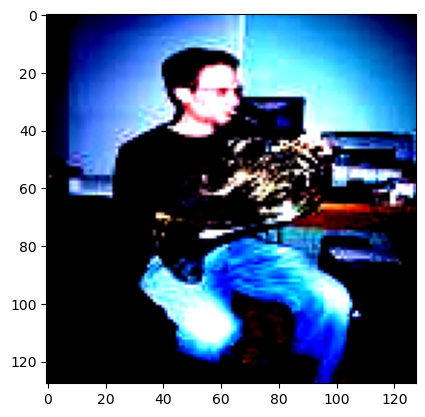

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0505886..2.3791833].


14 1


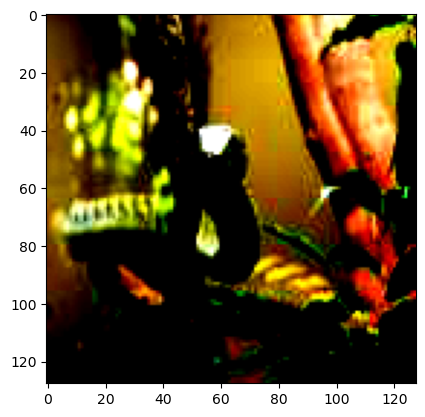

In [12]:
from matplotlib import pyplot as plt

name2label = json.load(open(f"{data_path}/class_name.json"))
label2name = {v:k for k, v in name2label.items()}

for idx, (images, labels) in enumerate(train_data):

    if idx > 1:
      break

    print(labels, idx)
    plt.imshow(images.permute(1, 2, 0))
    plt.show()

In [13]:
train_data[0][0].shape

torch.Size([3, 128, 128])

In [14]:
# import torch
# from torch.utils.data import DataLoader

# def get_mean_std(dataset):
    # loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    
    # mean = 0.
    # std = 0.
    # total_images_count = 0
    
    # for images, _ in loader:
    #     batch_samples = images.size(0) # 배치 크기
    #     images = images.view(batch_samples, images.size(1), -1)
    #     mean += images.mean(2).sum(0)
    #     std += images.std(2).sum(0)
    #     total_images_count += batch_samples
        
    # mean /= total_images_count
    # std /= total_images_count
    
    # return mean, std

In [15]:
# train_data = MyDataset(data_path, train=True, transform=transforms.ToTensor())
# get_mean_std(train_data)

model

In [16]:
from torchvision.models import resnet18, resnet34
import torch
import torch.nn as nn

# Torchvision 라이브러리에서 모델 불러오기
model = resnet18(pretrained=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.fc = nn.Linear(512,21, bias=True)

model = model.to(device)

print(model)

/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

훈련

In [ ]:
from sklearn.metrics import confusion_matrix
import ttach as tta

class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 scheduler=None, device=None, patience=5, save_path='best_model.pth'):
        
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizser = optimizer
        self.scheduler = scheduler
        self.save_path = save_path

        self.patience = patience
        self.patience_counter = 0
        self.best_acc = 0

        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        self.best_acc = 0

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(self.train_loader, leave=False)

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizser.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizser.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data,1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

            loop.set_description("Training")
            loop.set_postfix(loss=loss.item())
        
        avg_loss = running_loss / len(self.train_loader)
        acc = 100*correct/total
        return avg_loss, acc
    
    def val_epoch_with_tta(self):
        
        running_loss = 0.0
        correct = 0
        total = 0

        transforms = tta.Compose([
            tta.HorizontalFlip(),
            tta.Scale(scales=[1, 1.05]),
            tta.FiveCrops()
        ])
        tta_model = tta.ClassificationTTAWrapper(self.model, transforms)
        self.tta_model.eval()
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self.tta_model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data,1)
                correct += (predicted==labels).sum().item()
                total += labels.size(0)
        
        avg_loss = running_loss / len(self.val_loader)
        acc = 100*correct/total
        return avg_loss, acc

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data,1)
                correct += (predicted==labels).sum().item()
                total += labels.size(0)
        
        avg_loss = running_loss / len(self.val_loader)
        acc = 100*correct/total
        return avg_loss, acc

    def fit(self, epochs, print_f=1,tta=False):
        print(f'Epoch | Train Loss | Train Acc | Val Loss | Val Acc')
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch()
            if tta:
                val_loss, val_acc = self.val_epoch_with_tta()
            else:
                val_loss, val_acc = self.val_epoch()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            if epoch%print_f==0:
                print(f'[{epoch+1}/{epochs}] | {train_loss:.4f} | {train_acc:.2f}% | {val_loss:.4f} | {val_acc:.2f}%')

            if self.scheduler:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                self.patience = 0
                torch.save(self.model.state_dict(), self.save_path)
            else:
                self.patience += 1
                if self.patience_counter >= self.patience:
                    print('Early Stopping Triggered!')
                    break
            if epoch%print_f==0:
                print(f'[{self.patience_counter}/{self.patience}]')

        return self.history
    
    def plot_history(self):
        epochs = range(1,len(self.history['train_loss'])+1)

        plt.figure(figsize=(12,5))

        # Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'], label='Val Loss')
        plt.title('Loss History')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], label='Train Acc')
        plt.plot(epochs, self.history['val_acc'], label='Val Acc')
        plt.title('Accuracy History')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.show()

    def plot_confusion_matrix(self, class_names=None):
        """
        검증 데이터에 대한 Confusion Matrix 시각화
        Args:
            class_names: 클래스 이름 리스트 (예: ['Dog', 'Cat'])
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        
        # 최적의 모델 가중치 로드
        try:
            self.model.load_state_dict(torch.load(self.save_path))
            print("loaded best model for confusion matrix")
        except:
            print("warning: using current model weights instead of best model")

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # 혼동 행렬 계산
        cm = confusion_matrix(all_labels, all_preds)
        
        # 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names if class_names else "auto",
                    yticklabels=class_names if class_names else "auto")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

In [18]:
num_epochs = 1 # 바꿔보기

In [19]:
criterion = nn.CrossEntropyLoss() # 바꿔보기
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4) # 바꿔보기

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # 5 에포크마다 LR 0.1배 감소

trainer1 = Trainer(model,train_loader,val_loader,criterion,optimizer,scheduler,device,3)

history1 = trainer1.fit(num_epochs)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc


[1/1] | 2.3457 | 27.65% | 2.0858 | 35.43%
[0/0]


In [21]:
criterion = nn.CrossEntropyLoss() # 바꿔보기
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-2) # 바꿔보기

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

trainer2 = Trainer(model,train_loader,val_loader,criterion,optimizer,scheduler,device,3)

history2 = trainer2.fit(num_epochs)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc


[1/1] | 2.3573 | 27.02% | 2.4513 | 23.01%
[0/0]


In [25]:
criterion = nn.CrossEntropyLoss() # 바꿔보기
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-2) # 바꿔보기

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

trainer3 = Trainer(model,train_loader,val_loader,criterion,optimizer,scheduler,device,3)

history3 = trainer3.fit(num_epochs,1,True)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc


TypeError: FiveCrops.__init__() got an unexpected keyword argument 'height'

In [ ]:
model = resnet34(pretrained=False)
criterion = nn.CrossEntropyLoss() # 바꿔보기
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-2) # 바꿔보기

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

trainer2 = Trainer(model,train_loader,val_loader,criterion,optimizer,scheduler,device,3)

history2 = trainer2.fit(num_epochs)

In [ ]:
trainer1.plot_history()